# Project 4

### Question 9.1, Question 9.2

Stats for #gohawks
Average number of tweets per hour: 292.09326424870466
Average number of followers of users posting the tweets per tweet: 2217.9237355281984
Average number of retweets per tweet: 2.0132093991319877
-------------------------
Stats for #gopatriots
Average number of tweets per hour: 40.888695652173915
Average number of followers of users posting the tweets per tweet: 1427.2526051635405
Average number of retweets per tweet: 1.4081919101697078
-------------------------
Stats for #nfl
Average number of tweets per hour: 396.97103918228277
Average number of followers of users posting the tweets per tweet: 4662.37544523693
Average number of retweets per tweet: 1.5344602655543254


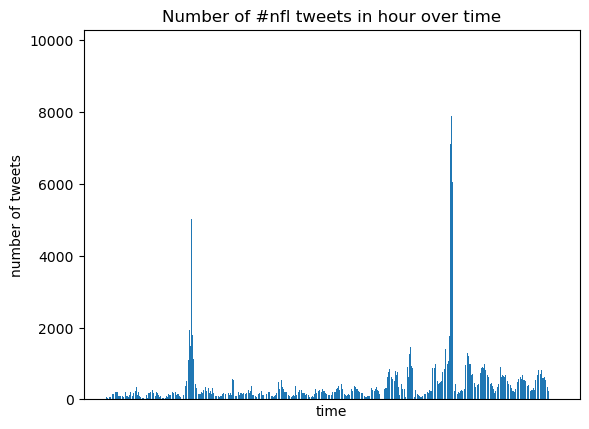

-------------------------
Stats for #patriots
Average number of tweets per hour: 750.6320272572402
Average number of followers of users posting the tweets per tweet: 3280.4635616550277
Average number of retweets per tweet: 1.7852871288476946
-------------------------
Stats for #sb49
Average number of tweets per hour: 1275.5557461406518
Average number of followers of users posting the tweets per tweet: 10374.160292019487
Average number of retweets per tweet: 2.52713444111402
-------------------------
Stats for #superbowl
Average number of tweets per hour: 2067.824531516184
Average number of followers of users posting the tweets per tweet: 8814.96799424623
Average number of retweets per tweet: 2.3911895819207736


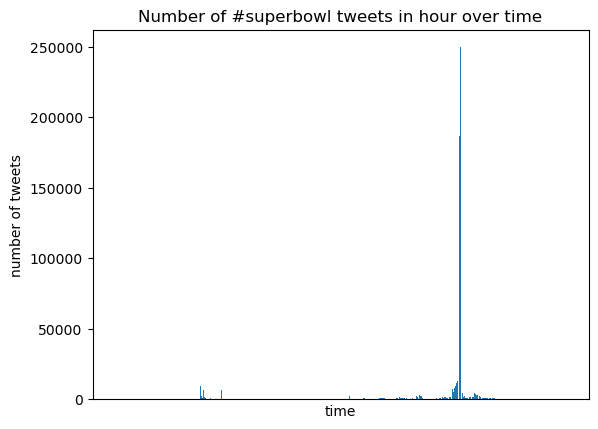

-------------------------


In [ ]:
import json
import math
import matplotlib.pyplot as plt

HASHTAGS = ['#gohawks', '#gopatriots', '#nfl', '#patriots', '#sb49', '#superbowl']
PLOT_HASHTAGS = {'#superbowl', '#nfl'}

# parse through every file
def parser(hashtag):
    plot = True if hashtag in PLOT_HASHTAGS else False

    tweet_count = 0
    followers = 0
    retweets = 0
    earliest_hour_key = math.inf
    latest_hour_key = 0
    if plot:
        tweets_per_hour = dict()

    with open(f'data/tweets_{hashtag}.txt', 'r') as f:
        for line in f:
            tweet_count += 1
            tweet = json.loads(line.strip())

            # accumulate tweets per hour
            hour_key = tweet['citation_date'] // 3600
            if hour_key < earliest_hour_key:
                earliest_hour_key = hour_key
            if hour_key > latest_hour_key:
                latest_hour_key = hour_key

            if plot:
                if hour_key not in tweets_per_hour:
                    tweets_per_hour[hour_key] = 1
                else:
                    tweets_per_hour[hour_key] += 1

            followers += int(tweet['author']['followers'])
            retweets += tweet['metrics']['citations']['total']

    # calculate average data
    num_hours = latest_hour_key - earliest_hour_key + 1
    average_tweets_per_hour = tweet_count / num_hours
    average_followers = followers / tweet_count
    average_retweets = retweets / tweet_count

    print(f'Stats for {hashtag}')
    print(f'Average number of tweets per hour: {average_tweets_per_hour}')
    print(f'Average number of followers of users posting the tweets per tweet: {average_followers}')
    print(f'Average number of retweets per tweet: {average_retweets}')

    if plot:
        x = list(range(earliest_hour_key, latest_hour_key+1))
        y = []
        for i in range(len(x)):
            y.append(tweets_per_hour.get(x[i], 0))
        plt.bar(x, y)
        plt.title(f'Number of {hashtag} tweets in hour over time')
        plt.xlabel('time')
        plt.xticks([])
        plt.ylabel('number of tweets')
        plt.show()

    print('-------------------------')

for hashtag in HASHTAGS:
    parser(hashtag)

### Question 10

##### Task
We believe that the way people talk on the Internet can give valuable information about the person. For instance, we feel that the location, time, and allegiance to a sports team can be predicted by the content and delivery of people through their Tweets. Thus, we have come up with the following tasks:

1. Given a tweet, predict
- which team they support
- when the tweet was posted (before / during / after the game)
- location of user

2. Generate a tweet for
- a Seahawk fan before the game
- a Seahawk fan after the game
- a Patriots fan before the game
- a Patriots fan after the game

As this is a natural langauge processing task, we used NLP lemmatization functions and dimensionality reduction methods similar to those in Project 1. The first task is a prediction task, so we will be using classification methods (binary and multi-class). The second task is a generation task so we relied on external models (GPT2) and fine-tuned the model to generate tweets in the same style as the training datasets. Detailed description will be done along the code blocks in later sections.

#### Data exploration
We first look at the dataset, and explore the different fields.

In [ ]:
import json

HASHTAGS = ['gohawks', 'gopatriots']

def extract_tweets(hashtag):
    team = 'hawks' if hashtag == 'gohawks' else 'patriots'
    tweets_data = []

    with open(f'data/tweets_#{hashtag}.txt', 'r') as f:
        for line in f:
            tweet = json.loads(line.strip())

            # remove tweets that contain both hawks and patriots hashtag
            hashtags = set()
            for h in tweet['tweet']['entities']['hashtags']:
                hashtags.add(h['text'])
            if 'gohawks' in hashtags and 'gopatriots' in hashtags:
                continue

            text = tweet['tweet']['text']
            location = tweet['tweet']['user']['location']
            time = tweet['citation_date']
            tweets_data.append(
                {'text': text,
                 'location': location,
                 'time': time,
                 'team': team}
            )

    return tweets_data

data = []
for hashtag in ['gopatriots']:
    data.extend(extract_tweets(hashtag))

In [ ]:
# check text
text_chars = set()
# check location
locations = set()

for obj in data:
    for char in obj['text']:
        text_chars.add(char)
    locations.add(obj['location'])

text_chars = sorted(list(text_chars))
print(f'Characters: \n{text_chars}')
print(f'Locations: \n{locations}')

Characters: 
['\n', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x80', '\x81', '\x82', '\x83', '\x84', '\x86', '\x87', '\x88', '\x89', '\x8a', '\x8b', '\x8c', '\x8d', '\x8e', '\x8f', '\x90', '\x91', '\x92', '\x93', '\x94', '\x95', '\x96', '\x97', '\x98', '\x99', '\x9a', '\x9b', '\x9c', '\x9d', '\x9f', '\xa0', '¡', '¢', '£', '¤', '¥', '¦', '§', '¨', '©', 'ª', '«', '¬', '\xad', '¯', '°', '±', '²', '³', '´', 'µ', '¶', '·', '¸', 'º', '»', '¼', '¾', '¿', 'Á', 'Â', 'Ã', 'Ä', 'Å', 'Æ', 'Ç', 'É', 'Ê', 'Í', 'Ð', 'Ñ', 'Ó', 'Ô', 'Õ', 'Ù', 'Ú', 'Ü', 'Þ', 'ß', 'à', 'á', 'â

From the list of characters and locations here, we can see that textual information is very varied and messy. For instance, the locations are not stored in proper formatting, with some locations being invalid (like empty strings or 'former capital'). Thus, location grouping and filtering of invalid location are required. To ensure tweets are as succinct as possible and mimic natural sentences, tweets are also passed through a formatting function.

#### Feature engineering

Many of the tweet features are continuous and not particularly useful to learn valuable information from the dataset. For instance, the time that the tweet was sent is a continuous value but does not serve any purpose. Thus, we categorized time based on whether it was before, during, or after the game, so that we can assign specific categories to the data and use them for targetted training. This was done in the 'get_time_period' function. We did consider other methods such as breaking into smaller buckets (based on how close to the game the tweet was sent), but we did not find it particularly useful in terms of sentiment analysis, so only 3 buckets were used for this feature.

Location of user was another problematic feature, because apart from missing / weird location data in quite a large sample of the dataset, the granularity of the location could dramatically affect model performance. Originally, we believed that most of the tweets would be from the US (since it is a US-based sporting event) so we wanted to limit specifically to the US and do grouping based on US states. However, after doing a count on the spread of countries within the dataset, we realized there was a non-negligible number of tweets from other nations. Also, due to the lack of a normalized formatting of the location, it was extremely difficult to parse the location to find the exact state that a user was from (a lot of location data do not follow the "{City}, {State}" format). Thus, we decided to implement a granularity of country and use an external library "country-named-entity-recognition" to decipher the country name from the location data.

In [ ]:
import json
import re

HASHTAGS = ['gohawks', 'gopatriots']

def clean_text(text):
    # 1. combine continuous whitespace to just one whitespace
    # 2. remove hyperlinks or references (starts with @)
    # 3. remove any hashtags
    # 4. substitute special characters
    words = []
    for word in text.strip().split():
        if not word.startswith('http') and not word.startswith('@') and not word.startswith('#'):
            word = re.sub('&lt;', '<', word)
            word = re.sub('&gt;', '>', word)
            word = re.sub('&amp;', '&', word)
            words.append(word)
    return ' '.join(words)

def get_time_period(time):
    # determine whether time is before, during, or after the game
    # game started on 6:30pm EST according to Wikipedia (https://en.wikipedia.org/wiki/Super_Bowl_XLIX)
    # game lasted 3 hr 36 min according to Yahoo Sports (https://ca.sports.yahoo.com/news/long-super-bowl-heres-average-113020689.html?)
    start_time = 1422829800
    end_time = start_time + (3 * 60 + 36) * 60
    if time < start_time:
        return 'before'
    if time >= end_time:
        return 'after'
    return 'during'


def extract_tweets(hashtag):
    team = 'hawks' if hashtag == 'gohawks' else 'patriots'
    tweets_data = []

    with open(f'data/tweets_#{hashtag}.txt', 'r') as f:
        for line in f:
            tweet = json.loads(line.strip())

            # remove tweets that contain both hawks and patriots hashtag
            hashtags = set()
            for h in tweet['tweet']['entities']['hashtags']:
                hashtags.add(h['text'])
            if 'gohawks' in hashtags and 'gopatriots' in hashtags:
                continue

            text = clean_text(tweet['tweet']['text'])
            location = tweet['tweet']['user']['location']
            time = get_time_period(tweet['citation_date'])

            tweets_data.append(
                {'text': text,
                 'location': location,
                 'time': time,
                 'team': team}
            )

    return tweets_data

data = []
for hashtag in HASHTAGS:
    data.extend(extract_tweets(hashtag))

# save data to a text file so it can be easily moved to Google Colab
with open('data.txt', 'w') as f:
    for d in data:
        json.dump(d, f)
        f.write('\n')

In [1]:
import json

# read from text file
try:
    with open('data.txt', 'r') as f:
        data = []
        for line in f:
            data.append(json.loads(line.strip()))
        print(len(data))
except:
    print('could not find data.txt file')

192613


#### Data Visualization
We generate word clouds for all tweets.

(-0.5, 999.5, 499.5, -0.5)

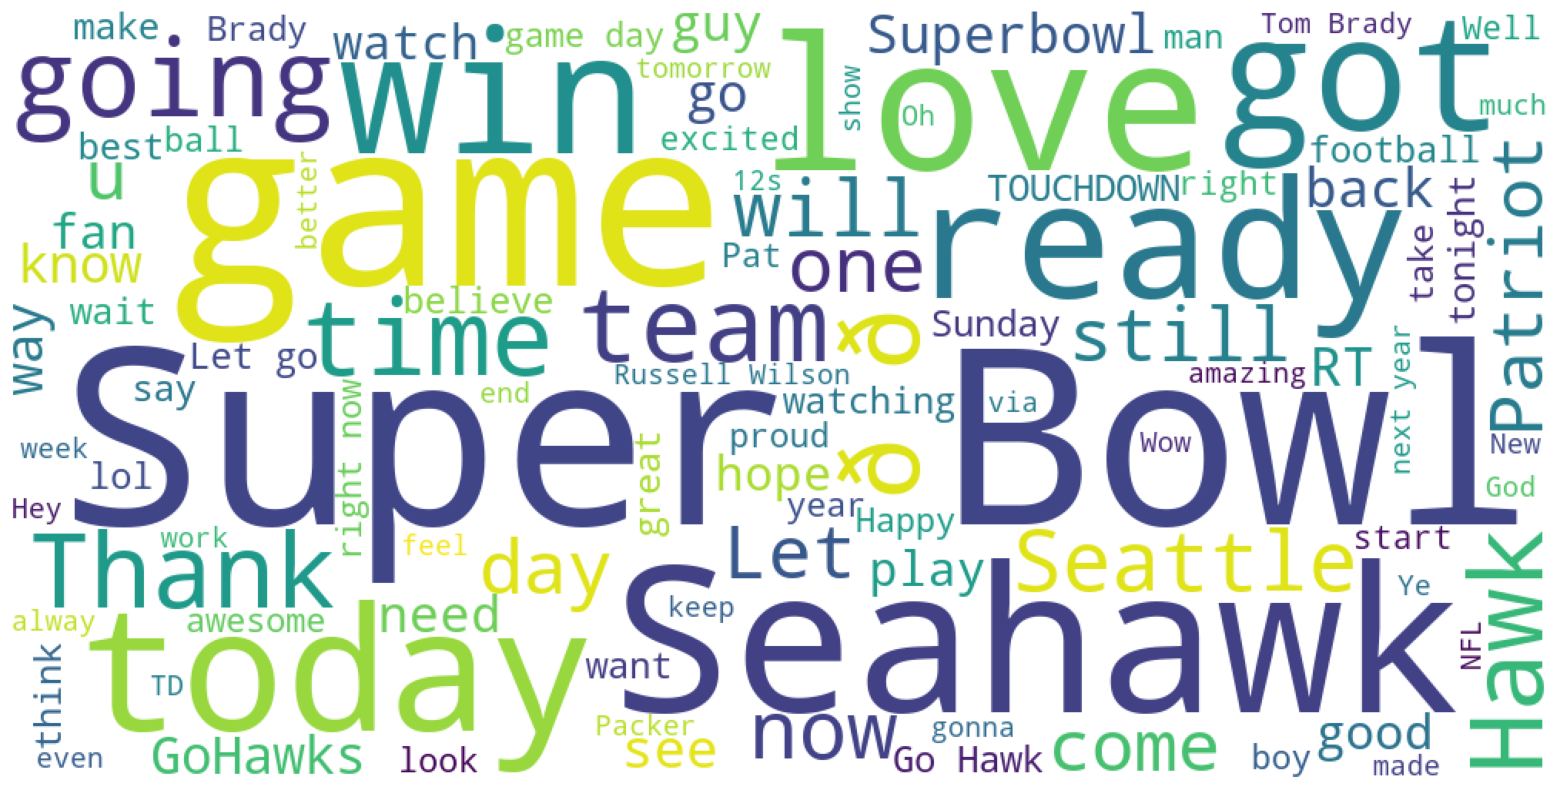

In [2]:
# Generate wordcloud
# from: https://medium.com/@bijil.subhash/generating-tweets-using-gpt-2-d93e1a87105a
import matplotlib.pyplot as plt
from wordcloud import WordCloud

text = " ".join(d['text'] for d in data)
wordcloud = WordCloud(width = 1000, height = 500, max_words=100, background_color="white").generate(text)

plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)
plt.axis("off")

#### 1.1 Predict team supported based on tweet

In [8]:
# team prediction

team_count = {'hawks': 0, 'patriots': 0}
for d in data:
    team_count[d['team']] += 1

print(team_count)

{'hawks': 169112, 'patriots': 23501}


To reduce imbalance in data, we undersample the 'hawks' dataset to match the size of the 'patriots' dataset.

In [9]:
import random

team_data = []
hawks = []
for d in data:
    if d['team'] == 'patriots':
        team_data.append(d)
    else:
        hawks.append(d)
random.shuffle(hawks)
team_data.extend(hawks[:23501])
random.shuffle(team_data)

new_team_count = {'hawks': 0, 'patriots': 0}
for d in team_data:
    new_team_count[d['team']] += 1

print(new_team_count)

{'hawks': 23501, 'patriots': 23501}


In [10]:
# from project 1
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [18]:
# from project 1
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk import pos_tag, wordnet
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, recall_score, roc_curve, precision_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from string import punctuation

In [12]:
# lemmatizer
wnl = wordnet.WordNetLemmatizer()

# from helper_code
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

# from helper_code
def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(list_word)]

analyzer = CountVectorizer().build_analyzer()

# get custom stop words, for filtering after lemmatization
# from helper_code
stop_words_skt = text.ENGLISH_STOP_WORDS
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en), set(punctuation), set(stop_words_skt))

# exclude word that are all numbers
def is_all_numbers(word):
    for char in word:
        # if character is not a number / negative sign / decimal point
        if not char.isdigit() and char != '-' and char != '.':
            return False
    return True

# from helper_code
def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not is_all_numbers(word))


def plot_roc(fpr, tpr, pipe_title):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    subplot_title = f'ROC curve for {pipe_title}'
    ax.title.set_text(subplot_title)
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def binaryclass_fit_predict_and_show_stats(pipe, train_data, train_label, test_data, test_label, binaryclass_labels, pipe_title):
    change_to_num = np.vectorize(lambda x: 0 if x==binaryclass_labels[0] else 1)
    new_train_label = change_to_num(train_label)
    new_test_label = change_to_num(test_label)

    pipe.fit(train_data, new_train_label)
    predicted = pipe.predict(test_data)
    cm = confusion_matrix(new_test_label, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)

    prob_score = pipe.predict_proba(test_data)
    fpr, tpr, _ = roc_curve(new_test_label, prob_score[:,1])

    # Plot ROC
    plot_roc(fpr, tpr, pipe_title)

    # Report stats
    print('----------')
    print(f"Stats for {pipe_title}")
    print(f"Accuracy score: {accuracy_score(new_test_label, predicted)}")
    print(f"Recall score: {recall_score(new_test_label, predicted)}")
    print(f"Precision score: {precision_score(new_test_label, predicted)}")
    print(f"F1 score: {f1_score(new_test_label, predicted)}")
    cm_display.plot()
    plt.show()
    print('----------')
    print()

def multiclass_fit_predict_and_show_stats(pipe, train_data, train_label, test_data, test_label, multiclass_labels, pipe_title):
    pipe.fit(train_data, train_label)
    predicted = pipe.predict(test_data)
    cm = confusion_matrix(test_label, predicted, labels=multiclass_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=multiclass_labels)

    # Report stats
    print('----------')
    print(f"Stats for {pipe_title}")
    print(f"Accuracy score: {accuracy_score(test_label, predicted)}")
    print(f"Recall score: {recall_score(test_label, predicted, average='micro')}")
    print(f"Precision score: {precision_score(test_label, predicted, average='micro')}")
    print(f"F1 score: {f1_score(test_label, predicted, average='micro')}")
    cm_display.plot()
    plt.show()
    print('----------')
    print()

Here we decided to use GaussianNB as a baseline. We expect Gaussian models to perform worse because they are better for handling data that follow Gaussian distributions, which are usually not the case for NLP tasks like this one. However, it is a good baseline model as based on empirical findings, GaussianNB models train much faster than the other models. We built a LogisticRegression model to compare against the baseline, and we expect the LogisticRegression model to perform better in terms of accuracy and other metrics.

75202 18802


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


Ready to train model
----------
Stats for GaussianNB
Accuracy score: 0.615360068077864
Recall score: 0.76111228144091
Precision score: 0.5927809680065628
F1 score: 0.6664821988562996


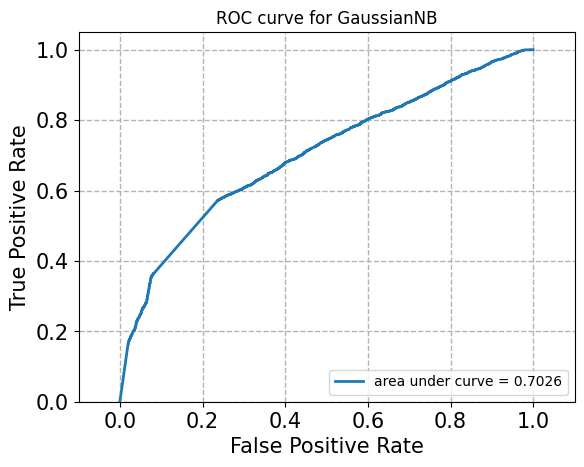

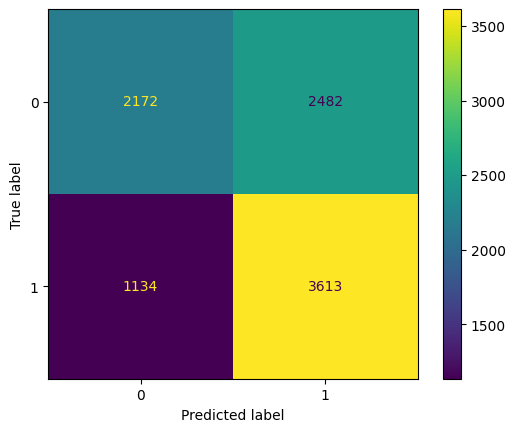

----------

----------
Stats for LogisticRegression
Accuracy score: 0.6839697904478247
Recall score: 0.7349905203286287
Precision score: 0.6707035755478662
F1 score: 0.7013770228163635


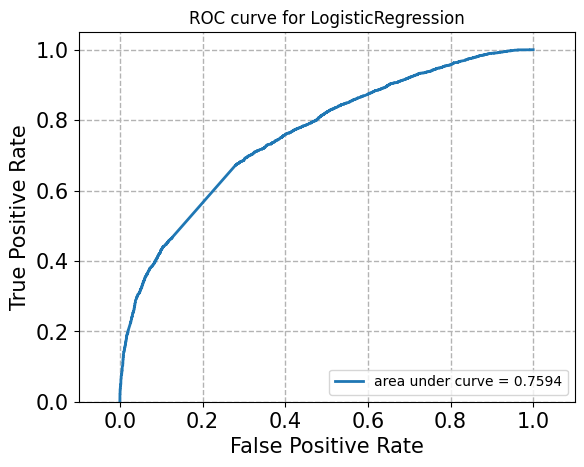

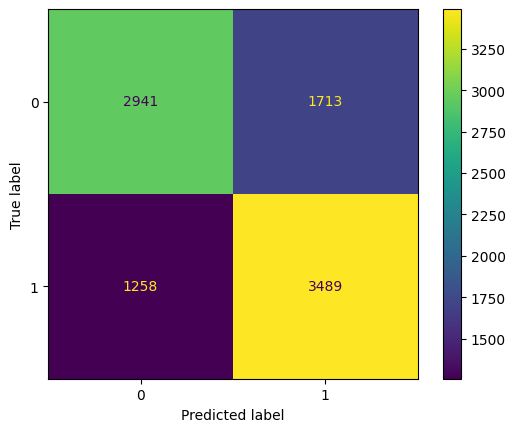

----------



In [23]:
# 1.1 train model to predict team supported
df = pd.DataFrame.from_records(team_data)
binaryclass_train, binaryclass_test = train_test_split(df[['text', 'team']], test_size=0.2)
print(binaryclass_train.size, binaryclass_test.size)

vectorizer = CountVectorizer(analyzer=stem_rmv_punc,
                             stop_words='english',
                             min_df=3)
binaryclass_train_lemmatized = vectorizer.fit_transform(binaryclass_train['text'])
binaryclass_test_lemmatized = vectorizer.transform(binaryclass_test['text'])

tfidf_transformer = TfidfTransformer()
binaryclass_train_tfidf = tfidf_transformer.fit_transform(binaryclass_train_lemmatized)
binaryclass_test_tfidf = tfidf_transformer.transform(binaryclass_test_lemmatized)


svd = TruncatedSVD(n_components=100, random_state=42)
binaryclass_train_lsi = svd.fit_transform(binaryclass_train_tfidf)
binaryclass_test_lsi = svd.transform(binaryclass_test_tfidf)

pipelines = [
    ('GaussianNB', Pipeline([('clf', GaussianNB())])),
    ('LogisticRegression', Pipeline([('clf', LogisticRegression(penalty='l1', C=1/0.01, solver='liblinear'))]))
]

print('Ready to train model')

LABELS = ['hawks', 'patriots']
for title, pipeline in pipelines:
    binaryclass_fit_predict_and_show_stats(pipeline,
                                        binaryclass_train_lsi,
                                        binaryclass_train['team'],
                                        binaryclass_test_lsi,
                                        binaryclass_test['team'],
                                        LABELS,
                                        title)

As expected, the LogisticRegression model performs better than the baseline GaussianNB model across accuracy and all metrics. Detailed evaluation will be done later on at the end of all 3 prediction tasks.

#### 1.2 Predict time period of posting based on tweet

In [24]:
# time period prediction

time_period_count = {'before': 0, 'during': 0, 'after': 0}
for d in data:
    time_period_count[d['time']] += 1

print(time_period_count)

{'before': 129815, 'during': 40918, 'after': 21880}


There are a lot fewer tweets from after the game, as compared to tweets before and during the game. To reduce imbalance in data, we undersample the 'before' and 'during' dataset to match the size of the 'after' dataset.

In [25]:
import random

time_data = []
time_data_dict = {'before': [], 'during': [], 'after': []}
for d in data:
    time_data_dict[d['time']].append(d)
time_data.extend(time_data_dict['after'])

random.shuffle(time_data_dict['before'])
time_data.extend(time_data_dict['before'][:21880])
random.shuffle(time_data_dict['during'])
time_data.extend(time_data_dict['during'][:21880])

random.shuffle(time_data)

new_time_count = {'before': 0, 'during': 0, 'after': 0}
for d in time_data:
    new_time_count[d['time']] += 1

print(new_time_count)

{'before': 21880, 'during': 21880, 'after': 21880}


105024 26256


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


Ready to train model
----------
Stats for GaussianNB
Accuracy score: 0.41803778184034124
Recall score: 0.41803778184034124
Precision score: 0.41803778184034124
F1 score: 0.41803778184034124


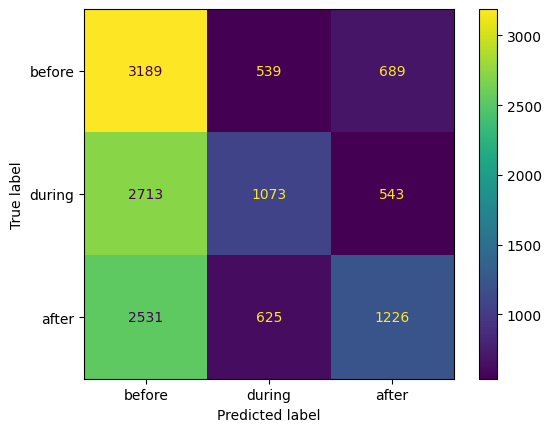

----------



In [26]:
# 1.2 train model to predict time period
df = pd.DataFrame.from_records(time_data)
multiclass_train, multiclass_test = train_test_split(df[['text', 'time']], test_size=0.2)
print(multiclass_train.size, multiclass_test.size)

vectorizer = CountVectorizer(analyzer=stem_rmv_punc,
                             stop_words='english',
                             min_df=3)
multiclass_train_lemmatized = vectorizer.fit_transform(multiclass_train['text'])
multiclass_test_lemmatized = vectorizer.transform(multiclass_test['text'])

tfidf_transformer = TfidfTransformer()
multiclass_train_tfidf = tfidf_transformer.fit_transform(multiclass_train_lemmatized)
multiclass_test_tfidf = tfidf_transformer.transform(multiclass_test_lemmatized)


svd = TruncatedSVD(n_components=50, random_state=42)
multiclass_train_lsi = svd.fit_transform(multiclass_train_tfidf)
multiclass_test_lsi = svd.transform(multiclass_test_tfidf)

pipelines = [
    ('GaussianNB', Pipeline([('clf', GaussianNB())]))
]

print('Ready to train model')

TIME_LABELS = ['before', 'during', 'after']
for title, pipeline in pipelines:
    multiclass_fit_predict_and_show_stats(pipeline,
                                        multiclass_train_lsi,
                                        multiclass_train['time'],
                                        multiclass_test_lsi,
                                        multiclass_test['time'],
                                        TIME_LABELS,
                                        title)

#### 1.3 Predict user location based on tweet

The "country-named-entity-recognition" tool is used to do natural langauge processing on the location

From: https://github.com/fastdatascience/country_named_entity_recognition

In [28]:
# if necessary
#!pip install country-named-entity-recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycountry: filename=pycountry-22.1.10-py2.py3-none-any.whl size=10595769 sha256=e2692343ab5a6cd242dda256948fd011e8b037238a329d545db0c03ff9299f71
  Stored in directory: /root/.cache/pip/wheels/72/d0/d2/87ac5f899a46bb9bd93d962289ae9c47ee975ffc10f7a25ae3
Successfully built pycountry


In [29]:
# location filtering
from country_named_entity_recognition import find_countries

def filter_location(data):
    filtered = []
    for obj in data:
        loc = obj['location'].strip()
        if not loc:
            continue
        countries = find_countries(loc, is_ignore_case=True)
        if len(countries) == 0:
            continue
        new_loc = countries[0][0].name
        new_obj = obj.copy()
        new_obj['location'] = new_loc
        filtered.append(new_obj)

    return filtered

loc_filtered_data = filter_location(data)
print(f'Original dataset length: {len(data)}\nFiltered location dataset length: {len(loc_filtered_data)}')

# check imbalance in location dataset
loc_filtered_data_dict = dict()
for obj in loc_filtered_data:
    if obj['location'] not in loc_filtered_data_dict:
        loc_filtered_data_dict[obj['location']] = 1
    else:
        loc_filtered_data_dict[obj['location']] += 1
ordered = sorted(list(loc_filtered_data_dict.items()), key=lambda x: x[1], reverse=True)
print(ordered)

Original dataset length: 192613
Filtered location dataset length: 12338
[('United States', 4617), ('Canada', 1533), ('United Kingdom', 945), ('Mexico', 767), ('Australia', 424), ('Brazil', 423), ('Germany', 330), ('Jersey', 250), ('Ireland', 221), ('France', 171), ('Colombia', 169), ('Venezuela, Bolivarian Republic of', 147), ('Argentina', 144), ('Japan', 123), ('Costa Rica', 121), ('Puerto Rico', 107), ('Guatemala', 102), ('Italy', 96), ('Chile', 90), ('Sweden', 77), ('Spain', 77), ('Netherlands', 63), ('Philippines', 59), ('Panama', 57), ('El Salvador', 56), ('Finland', 55), ('Austria', 46), ('Denmark', 43), ('New Zealand', 41), ('Ecuador', 39), ('Indonesia', 34), ('Norway', 33), ('Hong Kong', 30), ('Poland', 30), ('Jamaica', 28), ('Lebanon', 28), ('Paraguay', 28), ('Honduras', 26), ('Switzerland', 25), ('Marshall Islands', 25), ('Nicaragua', 25), ('Guam', 23), ('Peru', 20), ('Hungary', 19), ('Czechia', 19), ('Belgium', 18), ('Jordan', 18), ('India', 18), ('Luxembourg', 16), ('Tonga'

Due to the imbalance in data, we opt to remove tweets coming from locations that have less than 330 datapoints, and each country would only have 330 datapoints max.

In [30]:
import random
from country_named_entity_recognition import find_countries

ACCEPTABLE = ['United States', 'Canada', 'United Kingdom', 'Mexico', 'Australia', 'Brazil', 'Germany']

def filter_location(data, acceptable):
    filtered = dict()
    for obj in data:
        loc = obj['location'].strip()
        if not loc:
            continue
        countries = find_countries(loc, is_ignore_case=True)
        if len(countries) == 0:
            continue
        new_loc = countries[0][0].name
        # filter for only accepted countries
        if new_loc not in acceptable:
            continue
        new_obj = obj.copy()
        new_obj['location'] = new_loc
        if new_loc not in filtered:
            filtered[new_loc] = []
        filtered[new_loc].append(new_obj)

    return filtered

loc_filtered_data_all = filter_location(data, set(ACCEPTABLE))
loc_filtered_data = []
for country in loc_filtered_data_all:
    random.shuffle(loc_filtered_data_all[country])
    loc_filtered_data.extend(loc_filtered_data_all[country][:330])
random.shuffle(loc_filtered_data)

loc_filtered_data_dict = dict()
for obj in loc_filtered_data:
    if obj['location'] not in loc_filtered_data_dict:
        loc_filtered_data_dict[obj['location']] = 1
    else:
        loc_filtered_data_dict[obj['location']] += 1
ordered = sorted(list(loc_filtered_data_dict.items()), key=lambda x: x[1], reverse=True)
print(ordered)

[('United Kingdom', 330), ('Australia', 330), ('Canada', 330), ('United States', 330), ('Germany', 330), ('Mexico', 330), ('Brazil', 330)]


3696 924


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:539: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


Ready to train model
----------
Stats for GaussianNB
Accuracy score: 0.29653679653679654
Recall score: 0.29653679653679654
Precision score: 0.29653679653679654
F1 score: 0.29653679653679654


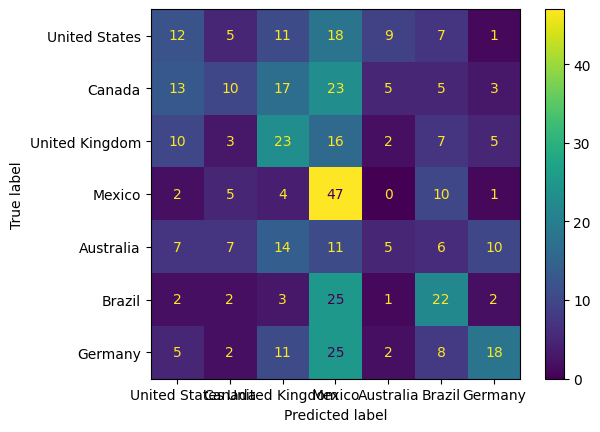

----------

----------
Stats for SVC
Accuracy score: 0.31601731601731603
Recall score: 0.31601731601731603
Precision score: 0.31601731601731603
F1 score: 0.31601731601731603


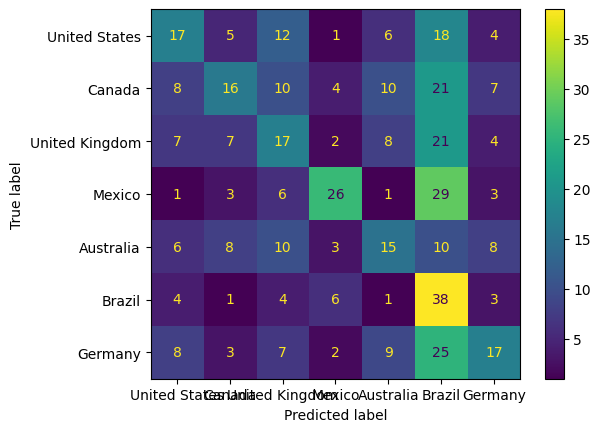

----------



In [33]:
# 1.3 train model to predict location
df = pd.DataFrame.from_records(loc_filtered_data)
multiclass_train, multiclass_test = train_test_split(df[['text', 'location']], test_size=0.2)
print(multiclass_train.size, multiclass_test.size)

vectorizer = CountVectorizer(analyzer=stem_rmv_punc,
                             stop_words='english',
                             min_df=3)
multiclass_train_lemmatized = vectorizer.fit_transform(multiclass_train['text'])
multiclass_test_lemmatized = vectorizer.transform(multiclass_test['text'])

tfidf_transformer = TfidfTransformer()
multiclass_train_tfidf = tfidf_transformer.fit_transform(multiclass_train_lemmatized)
multiclass_test_tfidf = tfidf_transformer.transform(multiclass_test_lemmatized)


svd = TruncatedSVD(n_components=300, random_state=42)
multiclass_train_lsi = svd.fit_transform(multiclass_train_tfidf)
multiclass_test_lsi = svd.transform(multiclass_test_tfidf)

pipelines = [
    ('GaussianNB', Pipeline([('clf', GaussianNB())])),
    ('SVC', Pipeline([('clf', OneVsRestClassifier(SVC(kernel='linear', C=500, probability=True, class_weight='balanced')))]))
]

print('Ready to train model')

for title, pipeline in pipelines:
    multiclass_fit_predict_and_show_stats(pipeline,
                                        multiclass_train_lsi,
                                        multiclass_train['location'],
                                        multiclass_test_lsi,
                                        multiclass_test['location'],
                                        ACCEPTABLE,
                                        title)

##### Evaluation of prediction task
We showcased our models for the prediction tasks and displayed the accuracies and metrics for each of the trained model. We also used baseline models to compare our model accuracies and display the performance improvement.

Comparing across all 3 prediction tasks, the team prediction model perform dramatically better than the others, with team prediction LogisticRegression model having an accuracy of 68.4%, while the time period prediction GaussianNB model only has an accuracy of 41.8% and the location prediction SVC model has an extremely low accuracy of 31.6%. This is consistent with our expectations, as we expect there to be more defining features that can be picked up from the tweet contents to determine which team the person supports, less discerning features for time period, and much less features for where the user is from. Plus, the number of datapoints for each of the task is different as well, with way fewer datapoints for the location prediction task (only 330 datapoints per country) in the datasets. This can be attributed to the dataset, as the lack of a proper formatting for the location data meant that it was harder to find good training data for location prediction. Since country-named-entity-recognition is quite a rudimentary library to identify countries, a possible improvement would be to use a better NLP model to understand and find the location based on location data, or to use a tweet dataset that provides better formatted location information.

One curious finding from the confusion matrix of the location prediction models was that Mexico and Brazil classes seemed to be labeled correctly more often than the other classes. This could be due to languages used, since people from both countries both primarily use their own specific languages (Spanish for Mexicans, and Portuguese for Brazilians), and these different languages are learnt by the models. While Germany also has its own native language, based on the tweet dataset, the vast majority of German users still communicate using English. For a fairer comparison where language differences are eliminated, a future task could be to only perform prediction task on tweets that are in English.

#### 2. Tweet generation
Finally, we attempt to generate a tweet from a supporter of either team, both before and after the game.

Referencing https://wandb.ai/wandb/huggingtweets/reports/Hugging-Tweets-Train-a-Model-to-Generate-Tweets--VmlldzoxMTY5MjI, tweets are separated by special tokens '<|endoftext|>', so that the model treats each tweet as independent datapoints.

In [ ]:
def split_tweets_based(data):
    hawks_before, hawks_after, patriots_before, patriots_after = [], [], [], []
    for obj in data:
        if obj['team'] == 'hawks':
            if obj['time'] == 'before':
                hawks_before.append(obj['text'])
            elif obj['time'] == 'after':
                hawks_after.append(obj['text'])
        else:
            if obj['time'] == 'before':
                patriots_before.append(obj['text'])
            elif obj['time'] == 'after':
                patriots_after.append(obj['text'])
    return hawks_before, hawks_after, patriots_before, patriots_after

hawks_before, hawks_after, patriots_before, patriots_after = split_tweets_based(data)

In [ ]:
# if necessary
# !pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 1.8 MB/s eta 0:00:00a 0:00:01


In [ ]:
with open('hawks_before.txt', 'w') as f:
    f.write('\n'.join(hawks_before))
with open('hawks_after.txt', 'w') as f:
    f.write('\n'.join(hawks_after))
with open('patriots_before.txt', 'w') as f:
    f.write('\n'.join(patriots_before))
with open('patriots_after.txt', 'w') as f:
    f.write('\n'.join(patriots_after))

In [ ]:
# if necessary
#!pip3 install gpt-2-simple

  Using cached gpt_2_simple-0.8.1-py3-none-any.whl


Running this model took extremely long as we are performing fine-tuning on a large language model. While the rest of the notebook was run locally, the following code block was run specifically on Google Colab to make use of the free GPU resource.

In [ ]:
# from: https://github.com/minimaxir/gpt-2-simple
import gpt_2_simple as gpt2

datasets = ['hawks_before.txt', 'hawks_after.txt', 'patriots_before.txt', 'patriots_after.txt']

# use GPT with 124 million parameters
gpt2.download_gpt2(model_name="124M")
sess = gpt2.start_tf_sess()
# from: https://medium.com/@bijil.subhash/generating-tweets-using-gpt-2-d93e1a87105a
gpt2.finetune(sess,
            dataset=datasets[0],
            #dataset=datasets[1],
            #dataset=datasets[2],
            #dataset=datasets[3],
            model_name='124M',
            steps=40,
            restore_from='fresh',
            run_name='run1',
            print_every=10,
            sample_every=25,
            save_every=25
            )

# this was run on Google Colab due to the lack of a GPU on local env
# have to disconnect and start new runtime for each instance of gpt2, so that it can be finetuned with only the correct dataset

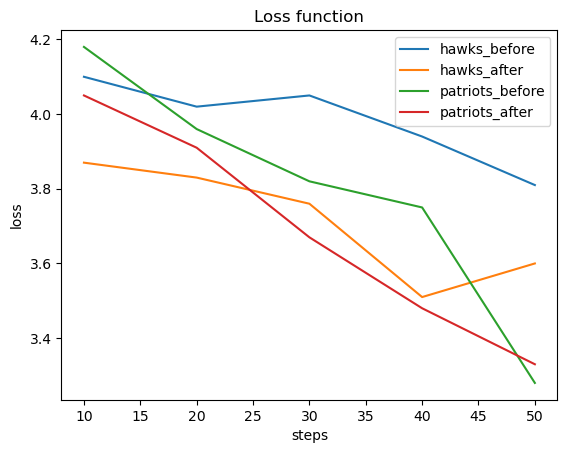

In [4]:
import matplotlib.pyplot as plt

steps = [10, 20, 30, 40, 50]
loss = dict()
loss['hawks_before'] = [4.10, 4.02, 4.05, 3.94, 3.81]
loss['hawks_after'] = [3.87, 3.83, 3.76, 3.51, 3.60]
loss['patriots_before'] = [4.18, 3.96, 3.82, 3.75, 3.28]
loss['patriots_after'] = [4.05, 3.91, 3.67, 3.48, 3.33]

for k in loss:
    plt.plot(steps, loss[k], label=k)
    plt.title(f'Loss function')
    plt.legend(loc='upper right')
    plt.xlabel('steps')
    plt.ylabel('loss')
    plt.show

We plotted the loss functions for all 4 models. We experimented with different number of training steps, but after training multiple iterations of models on all 4 datasets, we notice that the loss functions generally plateau and begin to increase after 40-50 steps. Thus, we chose to train the models with 40 steps.

##### Generate tweets
For each fine-tuned model, we generate some tweets with the same style. We chose one tweet from the generated tweets for each model and copied them below.

In [ ]:
# generate tweet
generated = gpt2.generate(sess, temperature=0.7, return_as_list=True)
print(generated[0])

##### A representative generated tweet for each category

Hawks fan before game:
"I'm ready to scream my heart out!"

Hawks fan after game:
"Just wanted to say thank you for an awesome season. We'll be back"

Patriots fan before game:
"I am ready for the Super Bowl tonight!"

Patriots fan after game:
"PATRIOTS! AHHHHHHH PATRIOTS!!!"

##### Evaluation
We successfully fine-tuned models based on 4 specific datasets classified according to team supported and time period. The generated tweets showed that the fine-tuned model can generate tweets that somewhat showcase the unique identifiers of each dataset. Hawks and Patriots fans were all very excited coming into the game. After Patriots' win in the game, Patriots fans celebrated the win while Hawks fans suffered from the loss of their team. This aligns with the generated tweets.

Fine-tuning large language models took a lot of compute resources and time, which reduced our ability to do extra experimentation and improvements to the training / finetuning process. Nevertheless, we experimented with the number of steps to perform fine-tuning, and decided on the value of 40 across all 4 models. The loss function showed that the models were indeed training as expected.

Some future works would include experimenting with other LLM models, or even building our own rudimentary LLM from scratch. We also noticed that the training dataset still contained a lot of noise despite our attempts of doing data cleaning in the earlier sections (removing of hyperlinks, special escape characters etc.) so more improvements could be done on doing better cleaning of the dataset.